In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.dates as mdates
import datetime
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm

In [2]:
BTC = yf.download('BTC-USD', start='2022-12-26', end='2022-12-27',  interval = '1m')
BTC = BTC['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
BTC.head()

Datetime
2022-12-26 00:00:00+00:00    16842.250000
2022-12-26 00:01:00+00:00    16841.634766
2022-12-26 00:02:00+00:00    16840.742188
2022-12-26 00:03:00+00:00    16841.238281
2022-12-26 00:04:00+00:00    16839.712891
Name: Adj Close, dtype: float64

In [4]:
BTC.tail()

Datetime
2022-12-26 23:55:00+00:00    16904.869141
2022-12-26 23:56:00+00:00    16912.722656
2022-12-26 23:57:00+00:00    16910.898438
2022-12-26 23:58:00+00:00    16920.123047
2022-12-27 00:00:00+00:00    16919.291016
Name: Adj Close, dtype: float64

In [5]:
ETH = yf.download('ETH-USD', start='2022-12-26', end='2022-12-27',  interval = '1m')
ETH = ETH['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
ETH.head()

Datetime
2022-12-26 00:00:00+00:00    1218.920166
2022-12-26 00:01:00+00:00    1218.788818
2022-12-26 00:02:00+00:00    1218.675781
2022-12-26 00:03:00+00:00    1218.585815
2022-12-26 00:04:00+00:00    1218.458252
Name: Adj Close, dtype: float64

In [7]:
ETH.tail()

Datetime
2022-12-26 23:55:00+00:00    1226.134766
2022-12-26 23:56:00+00:00    1226.687500
2022-12-26 23:57:00+00:00    1226.530396
2022-12-26 23:58:00+00:00    1226.849609
2022-12-27 00:00:00+00:00    1226.987061
Name: Adj Close, dtype: float64

In [8]:
BTC.describe()

count     1437.000000
mean     16856.605618
std         18.465898
min      16812.369141
25%      16844.267578
50%      16852.785156
75%      16867.039062
max      16920.123047
Name: Adj Close, dtype: float64

In [9]:
ETH.describe()

count    1437.000000
mean     1219.050472
std         2.121003
min      1214.335938
25%      1217.556152
50%      1219.349487
75%      1220.646729
max      1226.987061
Name: Adj Close, dtype: float64

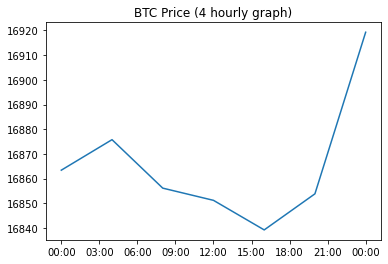

In [10]:
BTC_hourly = BTC.resample("4H").mean()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.plot(BTC_hourly)
plt.title("BTC Price (4 hourly graph)")
plt.show()

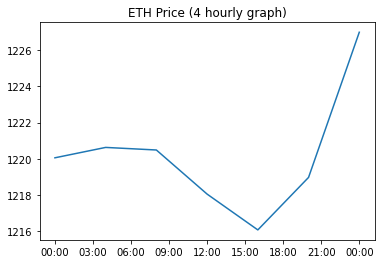

In [11]:
ETH_hourly = ETH.resample("4H").mean()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.plot(ETH_hourly)
plt.title("ETH Price (4 hourly graph)")
plt.show()

In [12]:
S1_0 = BTC[0]
S2_0 = ETH[0]

In [13]:
S1_0

16842.25

In [14]:
S2_0

1218.920166015625

# Estimation of Correlation Coefficient

In [15]:
lr1 = np.log(BTC / BTC.shift(1))
lr2 = np.log(ETH / ETH.shift(1))
rho = lr1.corr(lr2)
rho

0.630898294827874

In [16]:
result = linregress(np.log(BTC), np.log(ETH))
beta = result.slope

In [17]:
beta

1.3099483943813772

# Estimation of other parameters 

In [18]:
mu_1 = lr1.mean() * 1430
mu_2 = lr2.mean() * 1430
sigma_1 = lr1.std() * np.sqrt(1430)
sigma_2 = lr2.std() * np.sqrt(1430)
M = 1430 # in minutes
print(f'{M=}, {S1_0=}, {S2_0=}, {mu_1=}, {mu_2=}, {sigma_1=}, {sigma_2=}')

M=1430, S1_0=16842.25, S2_0=1218.920166015625, mu_1=0.004544771837186311, mu_2=0.006568702102843085, sigma_1=0.003806641575913428, sigma_2=0.004502970836763802


# Manually set parameters

In [19]:
z_0 = 0.00 # initial spread,
gamma = 0.5 # risk aversion coefficient
delta = 1 # speed of mean reversion
T = 1 # trading horizon, whole day = 1
dt = T/M

# Initialize simulation

In [20]:
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))

In [21]:
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = BTC[t-1]
    S2[t] = ETH[t-1]

# Plotting the price

Text(0.5, 1.0, 'Stock Price (BTC and ETH)')

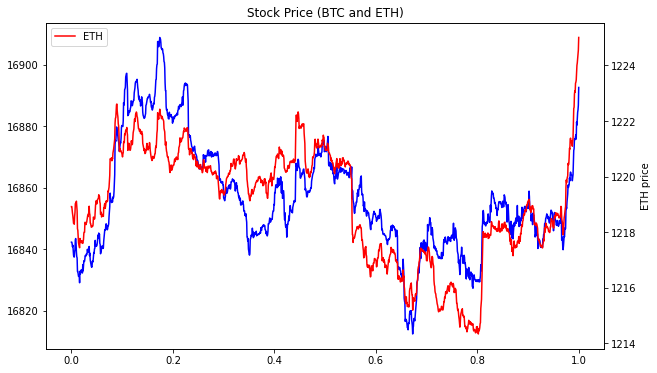

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S1, 'b', lw=1.5, label='BTC')

ax2 = plt.twinx()
ax2.plot(tt, S2, 'r', lw=1.5, label='ETH', axes=ax2)

plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('BTC price')
ax2.set_ylabel('ETH price')
plt.title('Stock Price (BTC and ETH)')


Text(0.5, 1.0, 'z')

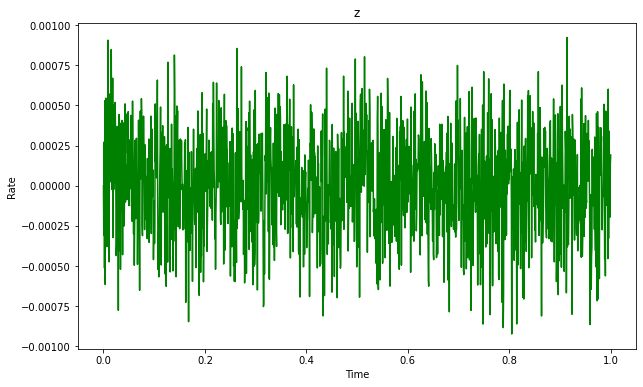

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('z')

# Optimal Trading Weights

In [24]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Optiamal control Weights')

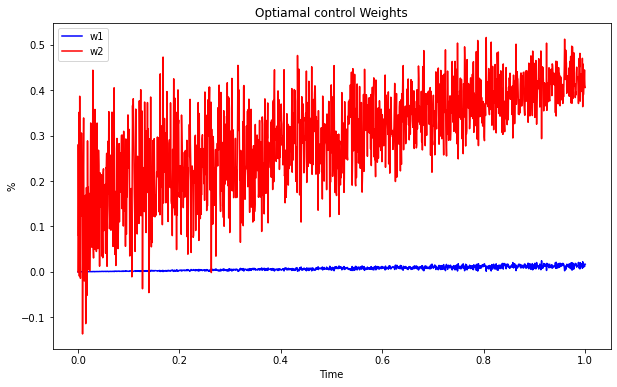

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='w1')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='w2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Optiamal control Weights')

# Optimal Cash Process

Text(0.5, 1.0, 'Optimal Cash Process')

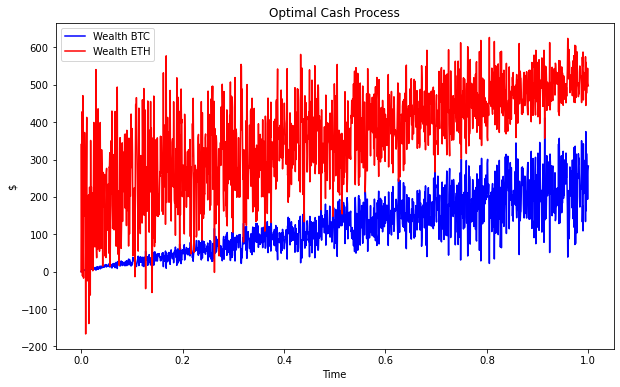

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1, 'b', lw=1.5, label='Wealth BTC')
plt.plot(tt, Pi_2 * S2, 'r', lw=1.5, label='Wealth ETH')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Optimal Cash Process')

In [27]:
Wealth = abs(Pi_1 * S1) + abs(Pi_2 * S2)

Text(0.5, 1.0, 'Wealth')

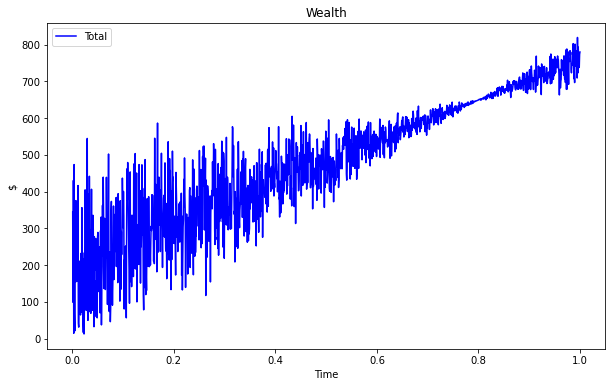

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(tt[1:], Wealth[1:], 'b', lw=1.5, label='Total')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Wealth')

# Static Control Pair

In [29]:
Pi_1.mean()

0.00707719624741895

In [30]:
Pi_2.mean()

0.29795841312956084

Text(0.5, 1.0, 'Comparison')

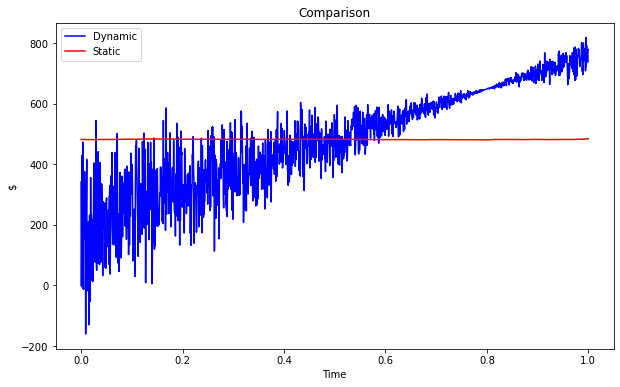

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1 + Pi_2 * S2, 'b', lw=1.5, label='Dynamic')
plt.plot(tt, Pi_1.mean() * S1 + Pi_2.mean() * S2, 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')

### Inital Wealth


In [32]:
Wealth[1]

array([344.15933694])

### Ending Wealth

In [33]:
Wealth[-1]

array([779.82217783])

### Return

In [34]:
(Wealth[-1] - Wealth[1])/Wealth[1]

array([1.26587541])

# Simulated prices for BTC and ETH

## Parameters

In [35]:
S1_0 = 16796.9765625
S2_0 = 1220.117919921875
mu_1 = 0.02
mu_2 = 0.01
sigma_1 = 0.1
sigma_2 = 0.05
z_0 = 0.01
beta = 0.8
gamma = 0.6
delta = 0.95
phi = 0.01
rho = -0.8
T = 1
M = 1430 

## Initialize simulation

In [36]:
dt = T/M
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))

In [37]:
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * z[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * rn1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

# Plot Price

Text(0.5, 1.0, 'Stock Price (BTC and ETH)')

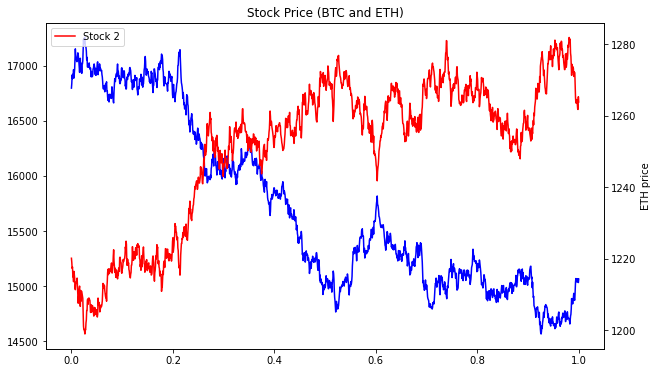

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S1, 'b', lw=1.5, label='Stock 1')

ax2 = plt.twinx()
ax2.plot(tt, S2, 'r', lw=1.5, label='Stock 2', axes=ax2)

plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('BTC price')
ax2.set_ylabel('ETH price')
plt.title('Stock Price (BTC and ETH)')


Text(0.5, 1.0, 'Alpha')

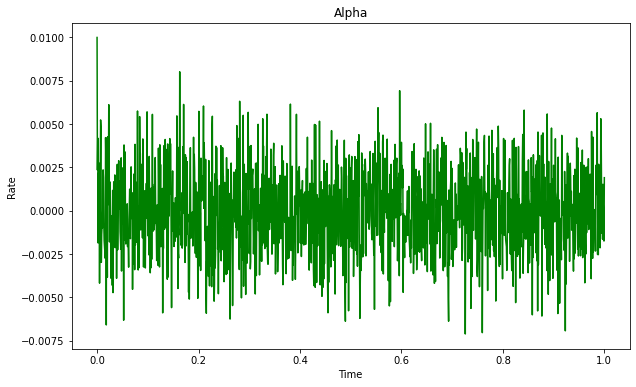

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Alpha')

# Optimal Trading Weights

In [40]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Optimal Control Weights')

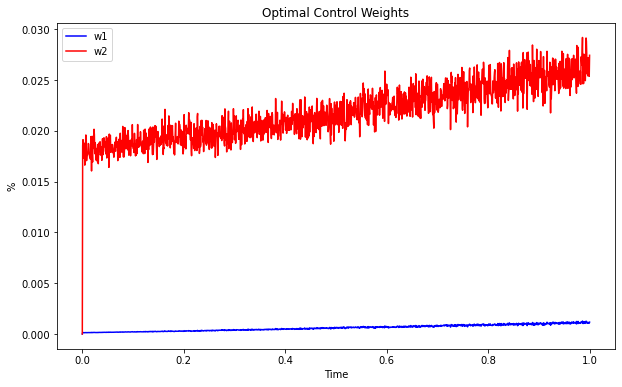

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='w1')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='w2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Optimal Control Weights')

# Optimal Cash Process

Text(0.5, 1.0, 'Cash')

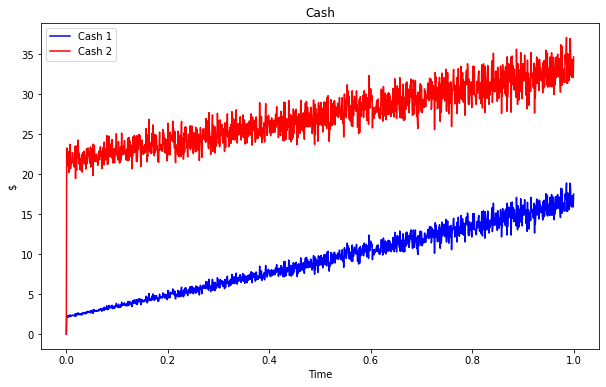

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1, 'b', lw=1.5, label='Cash 1')
plt.plot(tt, Pi_2 * S2, 'r', lw=1.5, label='Cash 2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Cash')

In [43]:
Pi_1.mean()

0.0005974641600317725

In [44]:
Pi_2.mean()

0.021796181896473282

Text(0.5, 1.0, 'Comparison')

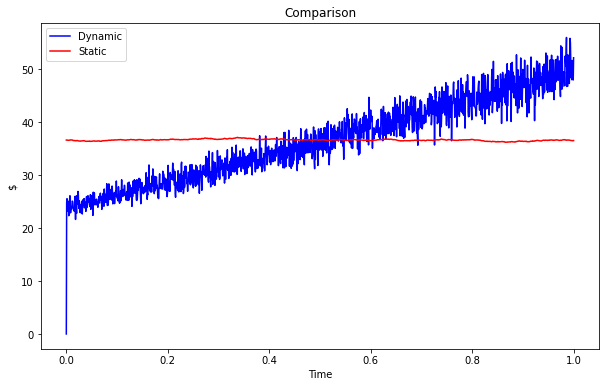

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1 + Pi_2 * S2, 'b', lw=1.5, label='Dynamic')
plt.plot(tt, Pi_1.mean() * S1 + Pi_2.mean() * S2, 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')

In [47]:
Wealth[1]

array([344.15933694])

In [48]:
Wealth[-1]

array([779.82217783])

In [49]:
(Wealth[-1] - Wealth[1])/Wealth[1]

array([1.26587541])

In [50]:
Wealth = abs(Pi_1 * S1) + abs(Pi_2 * S2)

Text(0.5, 1.0, 'Wealth')

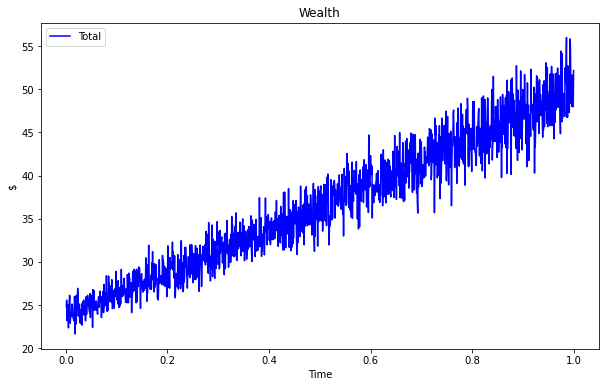

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(tt[1:], Wealth[1:], 'b', lw=1.5, label='Total')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Wealth')